<center>

# **MICRO-PROYECTO 2 CLUSTERING:** Esperanza de vida al nacer (años) 1990-2017.
---
Introducción a la Inteligencia Artificial, Código: 3010476

Inteligencia Artificial, Código: 3007855

---
**Integrantes :**

Juan Nicolas Piedrahita Salas

Juan José Monsalve

---
</center>


### **Objetivo**: Analizar la expectativa de vida de los diferentes países en un rango de tiempo de 1990 hasta 2017 usando un algoritmo de CLUSTERING similar al presentado en clase y en la práctica, se realizar un programa en Python que determine los clústeres en los datos del archivo .csv a partir de las tres variables que mejor segmentan los datos.

Importamos librerías necesarias.

In [1]:
from google.colab import files
import io

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib
from tabulate import tabulate 
import plotly.express as px
import plotly.graph_objects as go

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

## 1. Exploración de los datos

Pre-procesamientos que se hicieron en el archivo .csv de esperanza de vida al nacer (en años) por países. Se agruparon los países por su esperanza de vida al nacer en 3 años diferentes espaciados de la siguiente manera, (1990-1999, 2000-2008, 2009-2017). Además se determinará si existe alguna relación con el índice de desarrollo humano en el año 2017 por país. 

#### Pre-procesamientos hechos:
Al dataset de contienentes:
- se cambio el caracter "’", en el pais "Côte d’Ivoire" por "Côte d'Ivoire", ya que no los reconoce como iguales con el dataset de esperanza de vida

Al dataset de esperanza de vida:
- se ignoro la primera linea del archivo CSV
- se uso enconding "latin-1" ya que no lo reconocia como encoding "utf-8"
- se quitaron todas las columnas que no tenian nombre
- se ignoro las ultimas 6 lineas del archivo CSV, porque no tenian informacion util (se eliminan datos de monaco, san martino y nauru)
- se mesclaron los datos de forma aleatoria
- se elimino las filas que contenian algun valor nulo incluyendo los strings "..", "n.a"
- se elimino las filas duplicadas
- se cambio el tipo de dato a numerico a las columnas que lo requieren
- se agruparon los años en solo 3 rangos (1990-1999, 2000-2008, 2009-2017) por cada pais y se reemplazaron por el promedio en cada uno de esos rangos
- se combino con el dataset de continentes por el pais
- finalmente el dataframe quedo con las columasn que seran usadas en el analisis ("Continent", "Country", "PIB", "HDI Rank (2017)", "1990_1999", "2000_2008", "2009_2017")
- se normalizo el dataset para ser usado en el clustering

In [2]:
# leer la base de datos de continentes
uploaded = files.upload()
continentes = pd.read_csv(io.BytesIO(uploaded['Continentes.csv']))

# cambiar el caracter especial "’" en el pais "Côte d’Ivoire" por "Côte d'Ivoire", ya que no los reconoce como iguales
continentes["Country"] = continentes["Country"].str.replace("’", "'")

continentes.head()

Saving Continentes.csv to Continentes.csv


,Country,Continent,PIB
0,Afghanistan,Asia,19291.0
1,Albania,Europe,15279.0
2,Algeria,Africa,171091.0
3,Andorra,Europe,3154.0
4,Angola,Africa,88815.0


In [3]:
# leer la base de datos de expectativa de vida
uploaded = files.upload()
expect_vida = pd.read_csv(
    io.BytesIO(uploaded["Life expectancy at birth (years).csv"]),
    header=1,
    engine="python",
    encoding='latin-1',                                 # vota un error por algun caracter que no reconoce utf-8
    usecols=lambda namecol: "Unnamed" not in namecol,   # leer solo las columnas que tienen un nombre
    skipfooter=6,                                       # no considerar las ultimas  lineas, es informacion inutil (aca se eliminan los 3 ultimos paises)
    na_values = ["..", "n.a"]                           # considerar esos strings como NA
)
exp = expect_vida.copy()
# mesclar los datos
expect_vida = expect_vida.sample(frac=1)

# eliminar registros con NAs
expect_vida.dropna(inplace=True, subset=["HDI Rank (2017)"]) # eliminar registros que tienen esta columna nula
expect_vida.dropna(inplace=True, thresh=5) # eliminar registros que tienen mas de 5 NA

# eliminar registros duplicados
expect_vida.drop_duplicates(inplace=True)

# convertir columnas numericas al tipo de dato que les corresponde
expect_vida.iloc[:, 2:] = expect_vida.iloc[:, 2:].astype(np.float64)
expect_vida["HDI Rank (2017)"] = expect_vida["HDI Rank (2017)"].astype(np.int32)

# agrupar años en solo 3 rangos (1990-1999, 2000-2008, 2009-2017)
years = [str(y) for y in range(1990, 1999 + 1)]
expect_vida["1990_1999"] = expect_vida[years].mean(axis="columns")

years = [str(y) for y in range(2000, 2008 + 1)]
expect_vida["2000_2008"] = expect_vida[years].mean(axis="columns")

years = [str(y) for y in range(2009, 2017 + 1)]
expect_vida["2009_2017"] = expect_vida[years].mean(axis="columns")

# combinar con el la base de datos de continentes
expect_vida = pd.merge(expect_vida, continentes, on="Country")

# seleccionar solo columnas utiles
expect_vida = expect_vida[["Continent", "Country", "PIB", "HDI Rank (2017)", "1990_1999", "2000_2008", "2009_2017"]]

expect_vida.head()

Saving Life expectancy at birth (years).csv to Life expectancy at birth (years).csv


,Continent,Country,PIB,HDI Rank (2017),1990_1999,2000_2008,2009_2017
0,Africa,Chad,11314.0,186,47.34,48.066667,51.633333
1,Europe,Ireland,388698.0,4,75.60,78.366667,80.922222
2,Asia,Myanmar,76085.0,148,60.28,63.322222,65.944444
3,Africa,Liberia,3070.0,181,49.74,54.633333,61.055556
4,Europe,Czechia,250700.0,27,73.20,76.000000,78.200000


<h3>Despues de la limpieza, el dataframe quedo con las siguientes columnas</h3>
<center>

|variable| significado |
|--------|----------|
|Continent|Continente del pais|
|Country|Nombre del pais|
|PIB|Producto Interno Bruto del pais|
|HDI Rank (2017)|Human Development Index al año 2017|
|1990_1999|Promedio de la esperanza de vida en ese rango de años|
|2000_2008|Promedio de la esperanza de vida en ese rango de años|
|2009_2017|Promedio de la esperanza de vida en ese rango de años|
</center>

<h3>Y se eliminarion los siguientes paises</h3>

<center>

|pais| por que |
|--------|----------|
|Monaco|Se elimino al leer el dataframe ya que no se tiene ningun dato de el|
|Nauru|Se elimino al leer el dataframe ya que no se tiene ningun dato de el|
|San Marino|Se elimino al leer el dataframe ya que no se tiene ningun dato de el|
|Korea (Democratic People's Rep. of)|Se elimino ya que no tiene HDI rank|
|Somalia|Se elimino ya que no tiene HDI rank|
|Tuvalu|Se elimino ya que no tiene HDI rank|
|Marshall Islands|Se elimino ya que contiene demasidos NAs|
</center>

<h4>HDI es una columna muy importante ya que queremos establecer una relacion con esta columna y como no se tiene una forma de imputarlo con otras estadisticas se decide eliminar los paises que no lo tienen</h4>

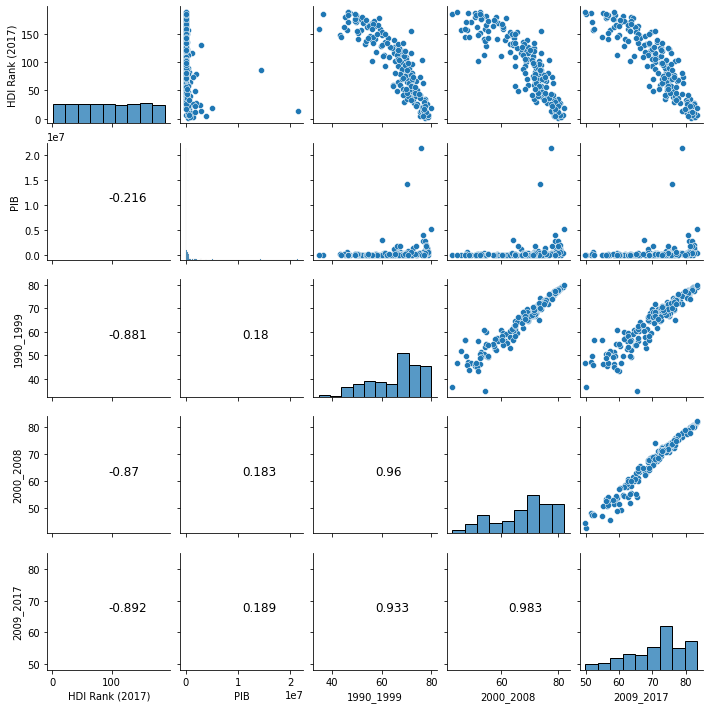

In [4]:
# matriz de correlaciones
grid = sb.pairplot(
    expect_vida,
    height=2, 
    vars=["HDI Rank (2017)", "PIB", "1990_1999", "2000_2008", "2009_2017"],
    kind='scatter'
)

def pintarCorr(x, y, **kwargs):
  plt.gca().clear()
  plt.gca().scatter(x, y, color="white")

  # calcular correlacion de pearson
  corr = round(np.corrcoef(x, y)[0,1], 3)
  plt.gca().text((max(x) + min(x))/2, (max(y) + min(y))/2, s=str(corr), fontsize=12)

# pintar la correlacion en la parte inferior de la diagonal
grid.map_lower(pintarCorr)

plt.show()

<h4>De la matriz de correlaciones se ve que si existe una correlacion lineal entre las columnas 1990_1999, 2000_2008, 2009_2017 y HDI Rank (2017), en este caso negativa, lo que significa que entre mayor son las columnas anteriores, menor es HDI Rank (2017)</h4>

In [5]:
# normalizar los datos que se usaran para hacer el clustering - USAR ESTA MATRIZ PARA LOS PUNTOS 2 Y 3
expect_vida_norm = MinMaxScaler().fit_transform(expect_vida[["1990_1999", "2000_2008", "2009_2017"]])

# 2. Cantidad óptima de clusters

A continuación, se explican las 3 técnicas utilizadas para establecer el numero de clústeres del conjunto de datos. (Método 1. Curva de codo, Método 2. Estadístico de gap, Método 3. Análisis de la Silueta) luego se analizara los resultados obtenidos y se justificara la respuesta. 

Se escogieron las columnas: "1990_1999", "2000_2008", "2009_2017". para hacer el clustering ya que se debian de escoger 3, y estas nos parecen que son las mas representativas y que contienen mas informacion util para analizar la esperanza de vida en los paises

### Elbow Curve

`inertia_`: Suma de las distancias cuadráticas de las muestras al centro del cluster mas cercano.

Este método usa la inercia como una medida de la variación intra-cluster e intenta minimizarla. Se debe tener en cuenta que la inercia óptima (mínima) sería cero, para el caso donde cada observación es su propio cluster; pero como esto no es de mucha utilidad, el métod del codo escoge como óptimo aquel valor del número de clusters a partir del cual añadir mas clusters solo consigue una mejora mínima de la inercia.

In [6]:
# se define la cantidad de clusters con los que se quiere probar
maxClusters = 10

In [7]:
def elbow_curve(data, maxClusters = 15):

  # rango de valores del parámetro a optimizar (cantidad de clusters)
  maxClusters = range(1, maxClusters + 1)
  inertias = []

  # se ejecuta el modelo para el rango de clusters y se guarda la inercia
  # respectiva obtenida para cada valor
  for k in maxClusters:
    kmeanModel = KMeans(n_clusters = k)
    kmeanModel.fit(expect_vida_norm)
    inertias.append(kmeanModel.inertia_)

  # Grafico de los resultados obtenidos para cada valor del rango
  print("Valores: ",inertias)
  plt.figure(figsize=(10, 8))
  plt.plot(maxClusters, inertias, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Inertia')
  plt.title('The Elbow Method showing the optimal k')
  plt.show()

Valores:  [31.31316736675283, 8.245982881991068, 4.768410737034009, 2.7853656610814155, 2.0192275358152383, 1.658755058051321, 1.3786499054871109, 1.162444060722391, 1.0614191044943362, 0.992500826089153]


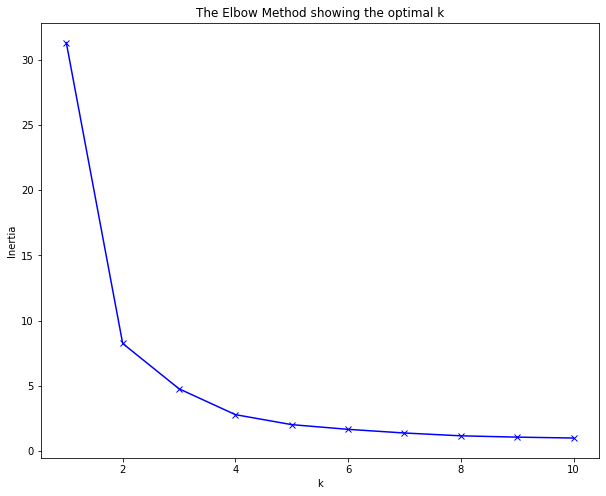

In [8]:
elbow_curve(expect_vida_norm, maxClusters = 10)

En el gráfico se puede ver claramente que a partir de k = 4 ya no hay una mejoría significativa en la reducción de la variación intra-cluster (inercia), por lo tanto, según este método, la cantidad óptima de clusters para agrupar estos datos es cuatro.

### Estadístico de Gap

El objetivo de este método es definir un procedimiento estadístico para formalizar la heurística de la curva de codo. De forma muy simplificada, el estadístico de gap compara, para diferentes valores de k, la variación total intracluster observada frente al valor esperado acorde a una distribución uniforme de referencia (datos de referencia).

El valor a elegir será el k mas pequeño tal que en k+1 el gráfico caiga (no necesariamente es el máximo absoluto de la curva de gap).

In [9]:
# nrefs es la cantidad de datos ("datasets") de referencia contra los que se va a comparar
def optimalK(data, nrefs=3, maxClusters=15):

    gaps = np.zeros((len(range(1, maxClusters+1)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters+1)):

        # guardara los resultados de dispersión de cada distribución simulada
        refDisps = np.zeros(nrefs)

        # Genera las muestras aleatorias indicadas con nrefs y ejecuta k-means
        # en cada bucle obteniendo los resultados de dispersión (inercia)
        # para cada conjunto generado.
        for i in range(nrefs):
            
            # Crea nuevo conjunto aleatorio de referencia
            # Se puede usar una semilla para tener reproducibilidad
            np.random.seed(0)
            randomReference = np.random.random_sample(size=data.shape)
            
            # se ajusta el modelo al conjunto de referencia
            km = KMeans(k)
            km.fit(randomReference)
            # se guarda la dispersión obtenida
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Se ajusta el modelo a los datos originales y se guarda su inercia
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calcula el estadístico de gap para k clusters usando el promedio de
        # las dispersiones de los datos simulados y la dispersión de los datos originales.
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Guarda el estadístico de gap obtenido en este bucle.
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    # Selecciona el "primer máximo" de los estadísticos obtenidos y devuelve 
    # su respectivo número de clusters    
    for i in range(0, len(gaps)-1):
      if gaps[i+1] <= gaps[i]:
        return (i+1, resultsdf)
    return (len(gaps), resultsdf)
    #return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal

In [10]:
k, gapdf = optimalK(expect_vida_norm, nrefs=5, maxClusters=15)
print('La cantidad óptima de clusters es: ', k)

La cantidad óptima de clusters es:  15


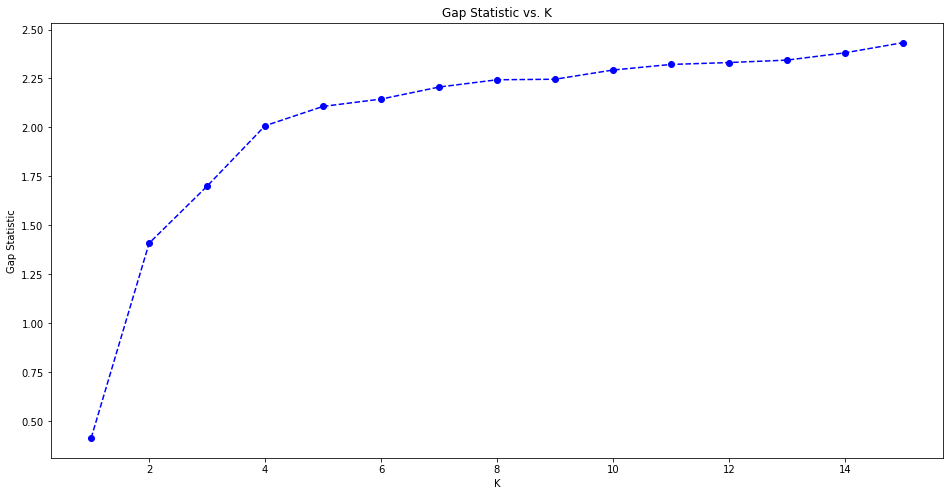

In [11]:
plt.figure(figsize=(16,8))
plt.plot(gapdf['clusterCount'], gapdf['gap'], linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Gap Statistic');
plt.title('Gap Statistic vs. K');

En el grafico se puede ver como en k = 9 el valor del estadístico de gap (que hasta ahora iba creciendo de forma constante) cae sutilmente respecto a su valor en k = 8; Según el estadístico de gap el numero optimo de clusters es 8 , que difiere mucho del resultado obtenido por el metodo del codo. 


### Coeficiente de Silueta

For n_clusters = 2 The average silhouette_score is : 0.641083296795381
For n_clusters = 3 The average silhouette_score is : 0.5171536761469289
For n_clusters = 4 The average silhouette_score is : 0.5273171136926982
For n_clusters = 5 The average silhouette_score is : 0.5156986622454348
For n_clusters = 6 The average silhouette_score is : 0.48871445855706624
For n_clusters = 7 The average silhouette_score is : 0.490399737663771
For n_clusters = 8 The average silhouette_score is : 0.46285951288228067
For n_clusters = 9 The average silhouette_score is : 0.46316536957539584
For n_clusters = 10 The average silhouette_score is : 0.46836821178428945


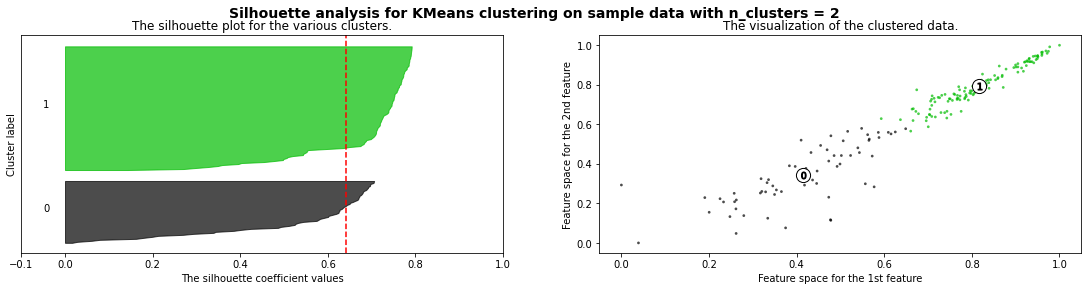

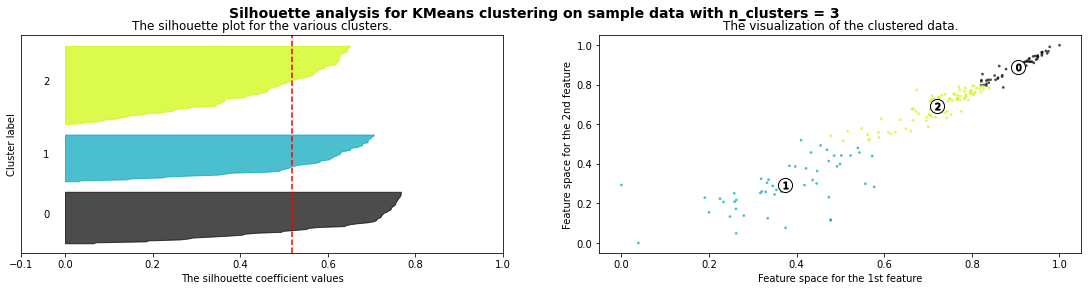

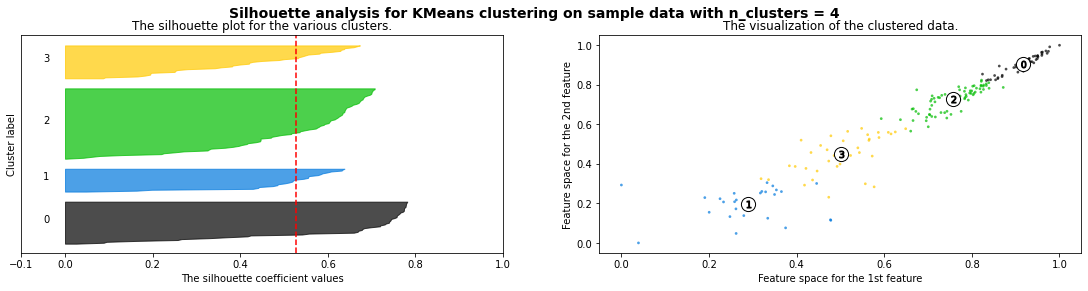

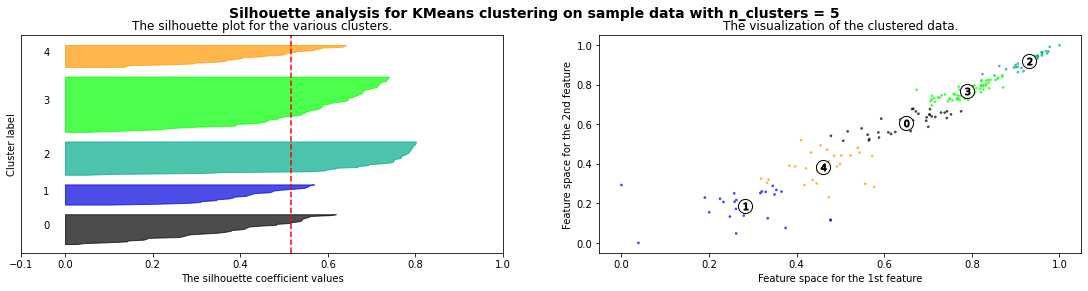

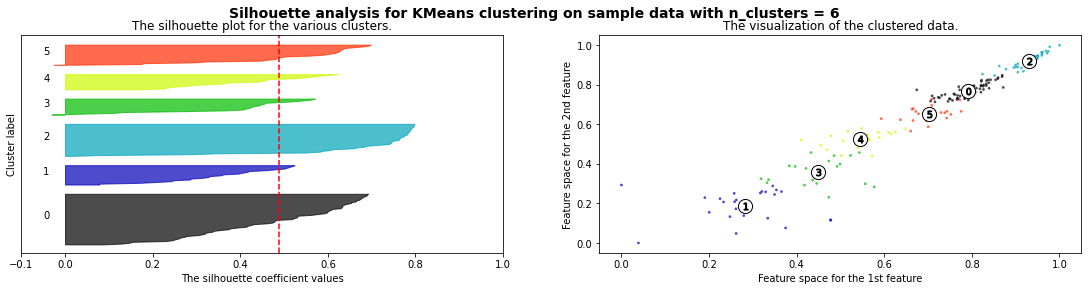

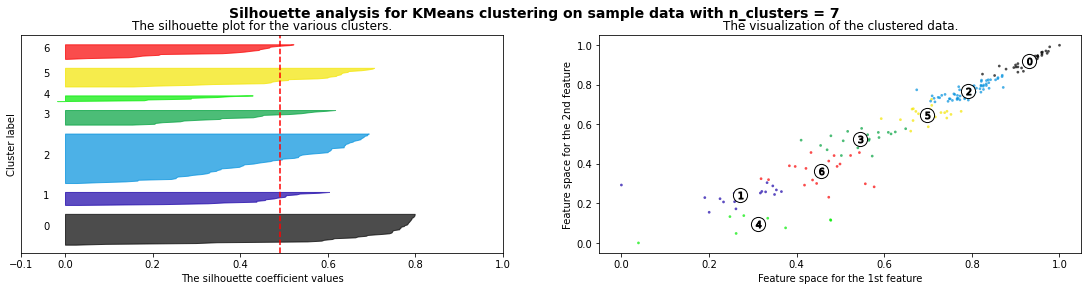

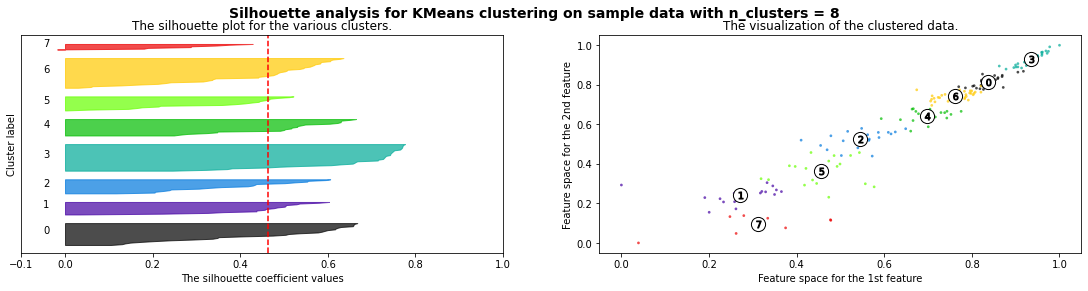

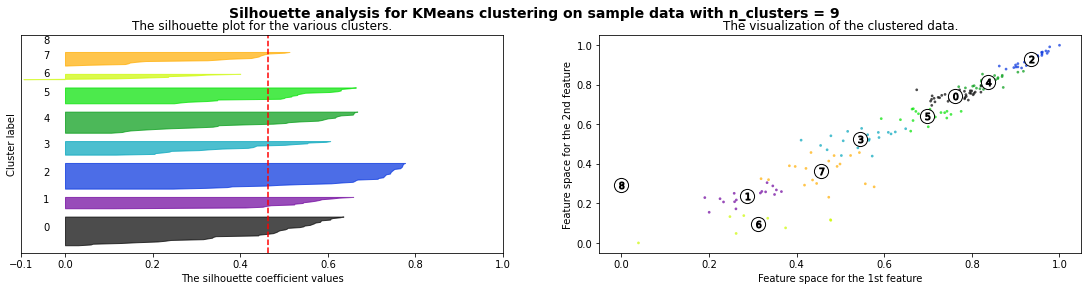

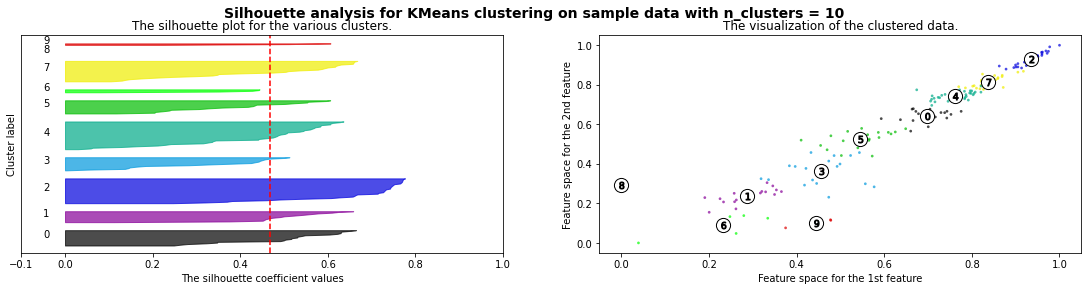

In [12]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

colors_k_means = ['cyan','purple','orange']
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
X = expect_vida_norm

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(19, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = plt.cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

Podemos ver que los puntajes mas altos se obtuvieron para 2, 3 y 4 clusters, pero se observa que los datos estan repartidos de forma mas equilibrada para k = 3, de igual manera no se puede descartar el resultado que arrojo en los 4 clusters. Por lo tanto, se puede considerar un empate en este método.



Teniendo en cuenta los resultados obtenidos en los diferentes métodos para determinar el número óptimo de clusters:

- Elbow Curve: 4
- Estadístico de Gap: 8
- Coeficiente de Silueta: 3 o 4

Por la diferencia tan grande que se presentó en el estadístico de Gap se decide descartar este resultado. Teniendo en cuenta los resultados obtenidos en Elbow Curve y Coeficiente de Silueta se tomó la decisión de: 

Entonces usaremos k = 4.


# 3. Dendrograma

El dendrograma nos da una representación grafica del diagrama de datos en forma de árbol que organiza los datos en subcategorías que se van dividiendo en otros hasta llegar al nivel de detalle deseado.

Este tipo de representación permite apreciar claramente las relaciones de agrupación entre los datos e incluso entre grupos de ellos aunque no las relaciones de similitud o cercanía entre categorías. 

Observando las sucesivas subdivisiones podemos hacernos una idea sobre los criterios de agrupación de estos, la distancia entre los datos según las relaciones establecidas, etc. El dendrograma ilustra las agrupaciones derivadas de la aplicación del algoritmo de clustering jerárquico.


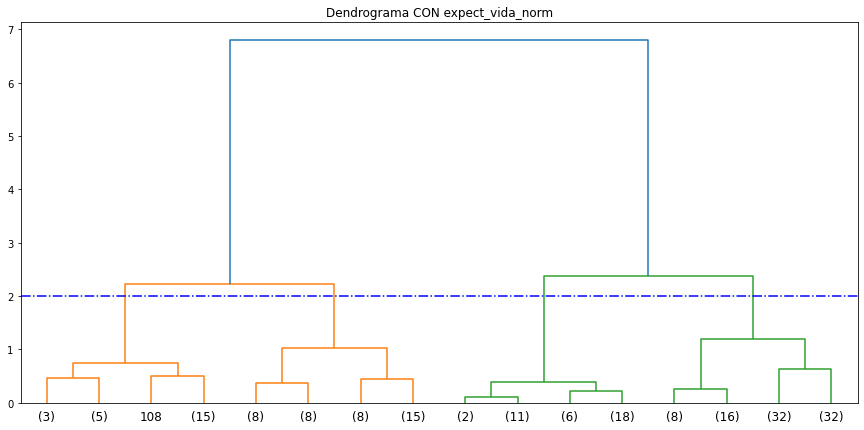

In [13]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(15, 7))  
plt.title("Dendrograma CON expect_vida_norm") 
dend = shc.dendrogram(shc.linkage(expect_vida_norm, method='ward'),truncate_mode='level',p=3)
plt.axhline(y=2, color='b', linestyle='-.')
plt.show()

Teniendo en cuenta los métodos anteriormente realizados para determinar el número óptimo de clustering, podemos escoger la altura adecuada en el dendrograma la cual será 2, la cual divide los datos en 4 grupos. Esto se puede evidenciar en la grafica del dendrograma. 

In [14]:
# clustering usando metodo aglomerativo
#Crear el modelo con la metrica euclidiana y vinculación minimizando la distancia.
# affinity=" " para otros criterios de similitud diferentes al euclidiano que viene por defecto
model=AgglomerativeClustering(n_clusters=4, linkage='ward')

#Aplicar el modelo
data_fit_3=model.fit(expect_vida_norm)
labels=data_fit_3.labels_

In [15]:
#Cómo están distribuidos los datos en el espacio

# #¿Como visualizar los clusters?

# kmeansModel = AgglomerativeClustering(4).fit(expect_vida_norm)
# lab_3c = kmeansModel.labels_

# X=np.array(expect_vida_norm)
# fig = plt.figure(figsize=(10, 8))
# ax = Axes3D(fig)
# ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=lab_3c, s=200,
#            cmap=matplotlib.colors.ListedColormap(['cyan','purple','orange']), alpha=0.5)
# plt.show()

# añadir los clusters a los datos
expect_vida["cluster"] = labels

fig = px.scatter_3d(expect_vida, x="1990_1999", y="2000_2008", z="2009_2017", color="cluster")
fig.show()

de la grafica de dispersion 3D podemos ver los 4 clusters bien definidos, no se solapan entre ellos y se ven bien definidos los limites entre clusters

# 4. Descripcion de caracteristicas por cluster

In [16]:
expect_vida.head()

,Continent,Country,PIB,HDI Rank (2017),1990_1999,2000_2008,2009_2017,cluster
0,Africa,Chad,11314.0,186,47.34,48.066667,51.633333,3
1,Europe,Ireland,388698.0,4,75.60,78.366667,80.922222,2
2,Asia,Myanmar,76085.0,148,60.28,63.322222,65.944444,1
3,Africa,Liberia,3070.0,181,49.74,54.633333,61.055556,1
4,Europe,Czechia,250700.0,27,73.20,76.000000,78.200000,0


### Grafico de estadisticos descriptivos de cada columna por cluster y continente
(las columnas "1990_1999", "2000_2008", "2009_2017", se grafican juntas ya que muestran una relacion entre ellas)

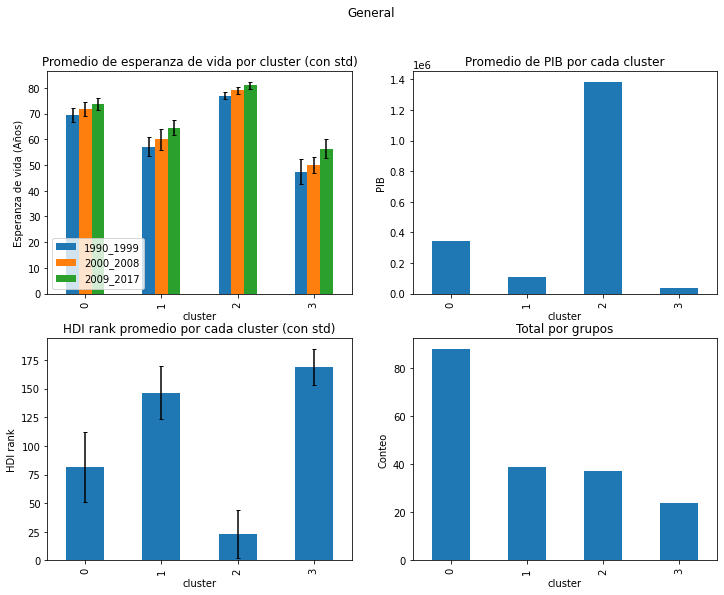

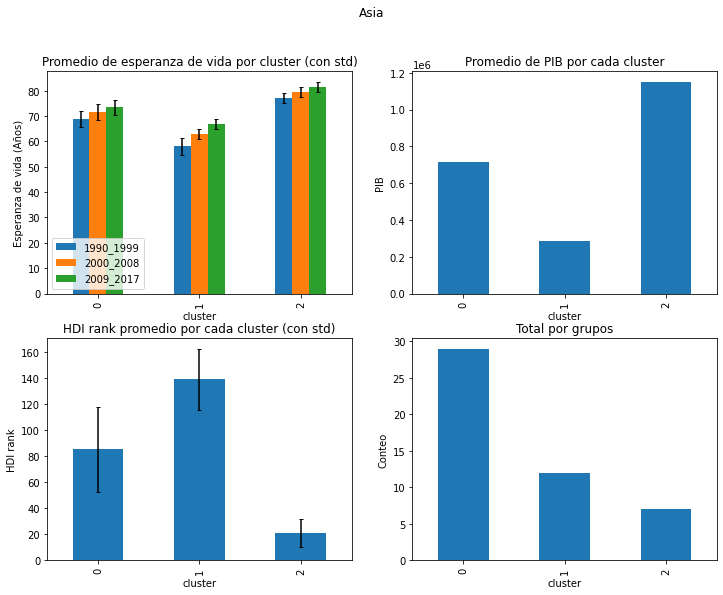

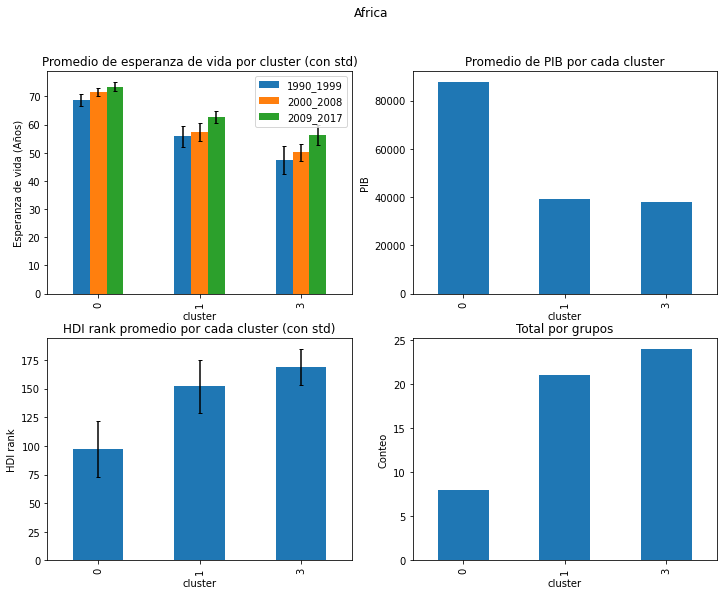

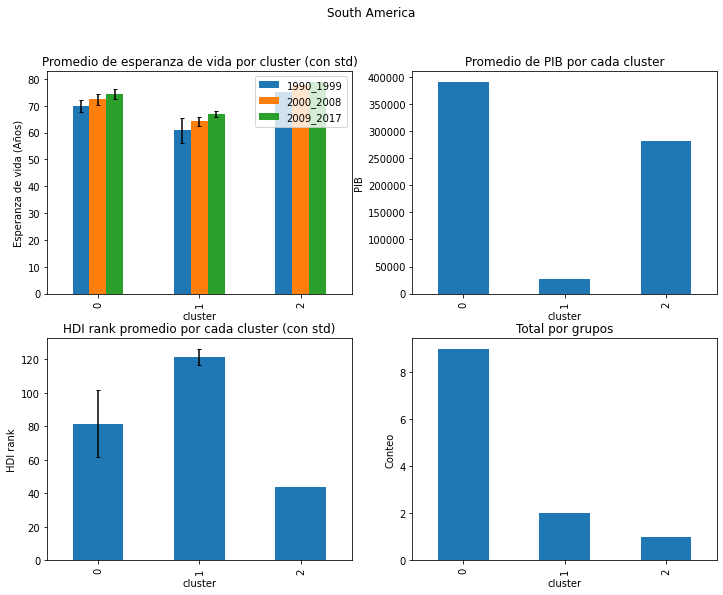

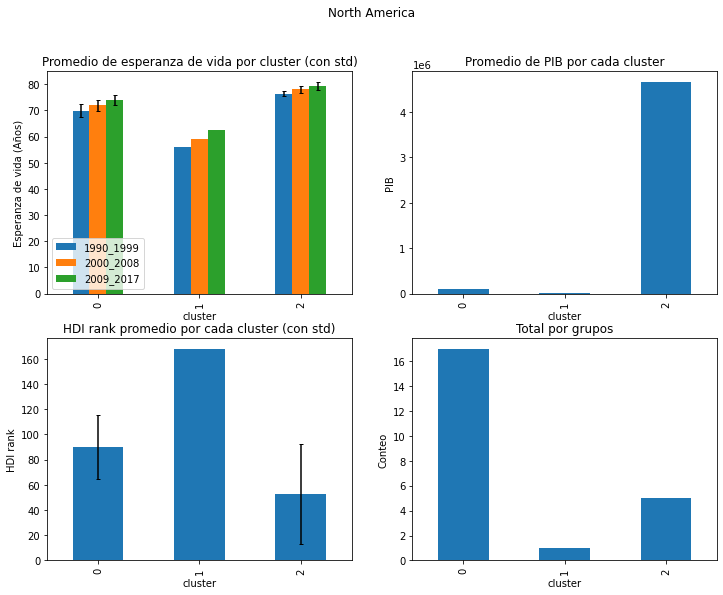

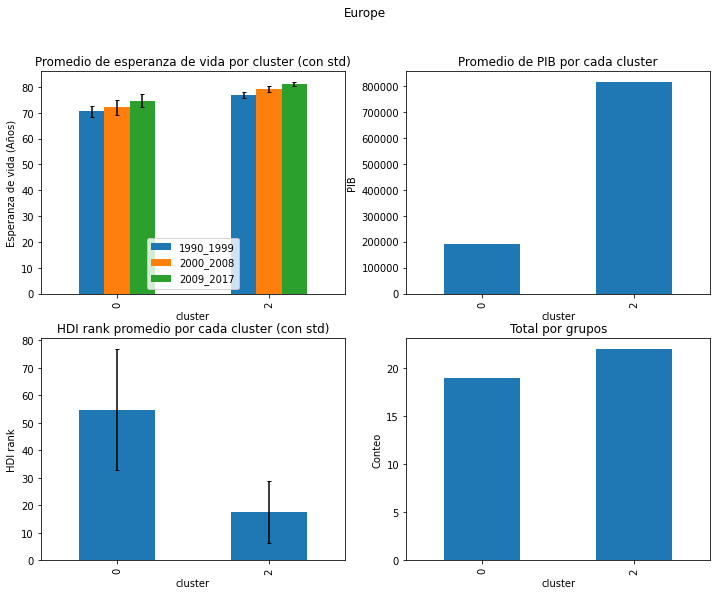

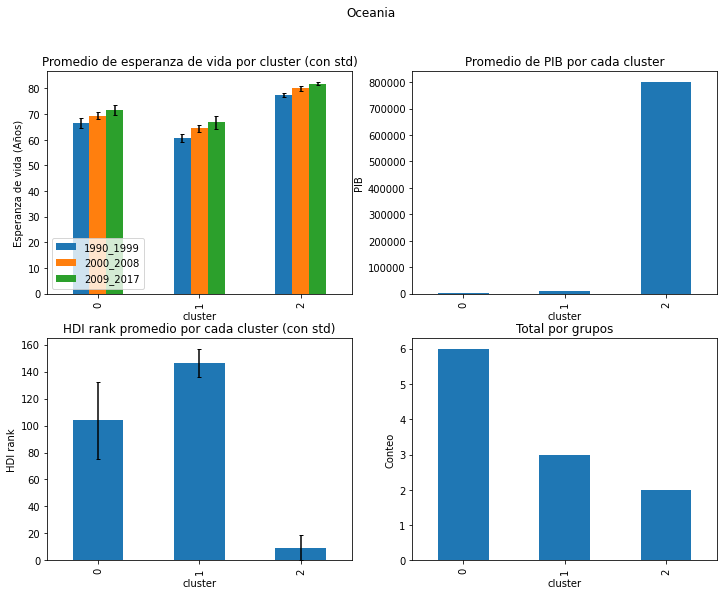

In [17]:
def mostrar_promedios(continente=None):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, facecolor="w", figsize=(12,9))

    if continente == None:
        expect_vida_gr = expect_vida.groupby("cluster")
    else:
        expect_vida_gr = expect_vida.query("Continent == @continente").groupby("cluster")

    # mostrar columnas "1990_1999", "2000_2008", "2009_2017"
    prom_por_cluster = expect_vida_gr[["1990_1999", "2000_2008", "2009_2017"]].mean()
    std_por_cluster = expect_vida_gr[["1990_1999", "2000_2008", "2009_2017"]].std()
    prom_por_cluster.plot.bar(ax=ax1, yerr=std_por_cluster, capsize=2)
    ax1.set_title("Promedio de esperanza de vida por cluster (con std)")
    ax1.set_ylabel("Esperanza de vida (Años)")


    # mostrar columna PIB
    prom_por_cluster = expect_vida_gr["PIB"].mean()
    # std_por_cluster = expect_vida_gr["PIB"].std()
    # prom_por_cluster.plot.bar(figsize=(4.5,3.5), yerr=std_por_cluster, capsize=2)
    prom_por_cluster.plot.bar(ax=ax2)
    ax2.set_title("Promedio de PIB por cada cluster")
    ax2.set_ylabel("PIB")
    # para el PIB la desviacion estandar es muy grande, por lo que no se muestra en la grafica, que la desviacion estandar sea tan grande nos
    # quiere decir que los datos del PIB estan muy dispersos en cada cluster


    # mostrar columna HDI Rank (2017)
    prom_por_cluster = expect_vida_gr["HDI Rank (2017)"].mean()
    std_por_cluster = expect_vida_gr["HDI Rank (2017)"].std()
    prom_por_cluster.plot.bar(ax=ax3, yerr=std_por_cluster, capsize=2)
    ax3.set_title("HDI rank promedio por cada cluster (con std)")
    ax3.set_ylabel("HDI rank")


    # mostar total por cluster
    expect_vida_gr.size().plot.bar(ax=ax4)
    ax4.set_title("Total por grupos")
    ax4.set_ylabel("Conteo")

    plt.suptitle("General" if continente == None else continente)
    plt.show()

for cont in [None, 'Asia', 'Africa', 'South America', 'North America', 'Europe', 'Oceania']:
    mostrar_promedios(cont)

# en algunos clusters sale un warning al hallar la std, eso es porque en ese continente y cluster especifico solo cayo un 1 pais

### ejemplo de paises por cluster

In [18]:
expect_vida.groupby("cluster")["Country"].apply(lambda paises: ",".join(paises)).to_frame()

,Country
cluster,
0,"Czechia,Turkey,Libya,Slovakia,Estonia,Palau,Ka..."
1,"Myanmar,Liberia,Lao People's Democratic Republ..."
2,"Ireland,Finland,Norway,Denmark,Costa Rica,Belg..."
3,"Chad,Guinea-Bissau,Guinea,Malawi,Zimbabwe,Nige..."


### ejemplo de paises por continente y cluster

In [19]:
cluster_por_cont = expect_vida.groupby(["Continent", "cluster"])["Country"].apply(lambda paises: ",".join(paises)).to_frame()
cluster_por_cont["Total"] = expect_vida.groupby(["Continent", "cluster"])["Country"].count()
cluster_por_cont

Country  \
Continent     cluster                                                      
Africa        0        Libya,Tunisia,Cabo Verde,Morocco,Mauritius,Egy...   
              1        Liberia,Senegal,Ghana,Namibia,South Africa,Eri...   
              3        Chad,Guinea-Bissau,Guinea,Malawi,Zimbabwe,Nige...   
Asia          0        Turkey,Kazakhstan,Kuwait,Iraq,Jordan,Banglades...   
              1        Myanmar,Lao People's Democratic Republic,Timor...   
              2        Hong Kong, China (SAR),Singapore,Cyprus,Israel...   
Europe        0        Czechia,Slovakia,Estonia,Serbia,Moldova (Repub...   
              2        Ireland,Finland,Norway,Denmark,Belgium,Iceland...   
North America 0        Guatemala,Panama,Belize,Bahamas,Grenada,Nicara...   
              1                                                    Haiti   
              2            Costa Rica,United States,Cuba,Canada,Dominica   
Oceania       0        Palau,Fiji,Vanuatu,Micronesia (Federated State...   
              1                Solomon Islands,Papua New Guinea,Kiribati   
              2                                    New Zealand,Australia   
South America 0        Suriname,Peru,Paraguay,Colombia,Argentina,Vene...   
              1                  Bolivia (Plurinational State of),Guyana   
              2                                                    Chile   

                       Total  
Continent     cluster         
Africa        0            8  
              1           21  
              3           24  
Asia          0           29  
              1           12  
              2            7  
Europe        0           19  
              2           22  
North America 0           17  
              1            1  
              2            5  
Oceania       0            6  
              1            3  
              2            2  
South America 0            9  
              1            2  
              2            1

### graficos de pares por cluster

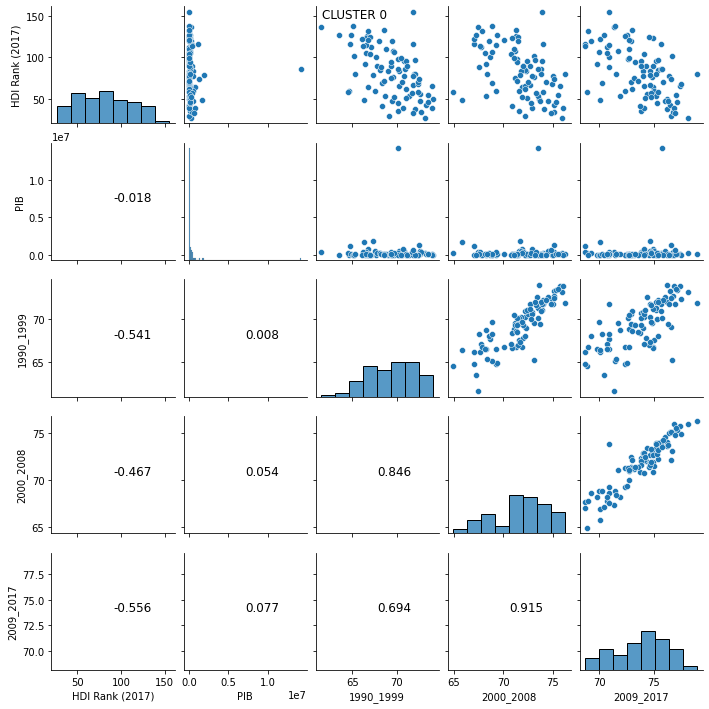

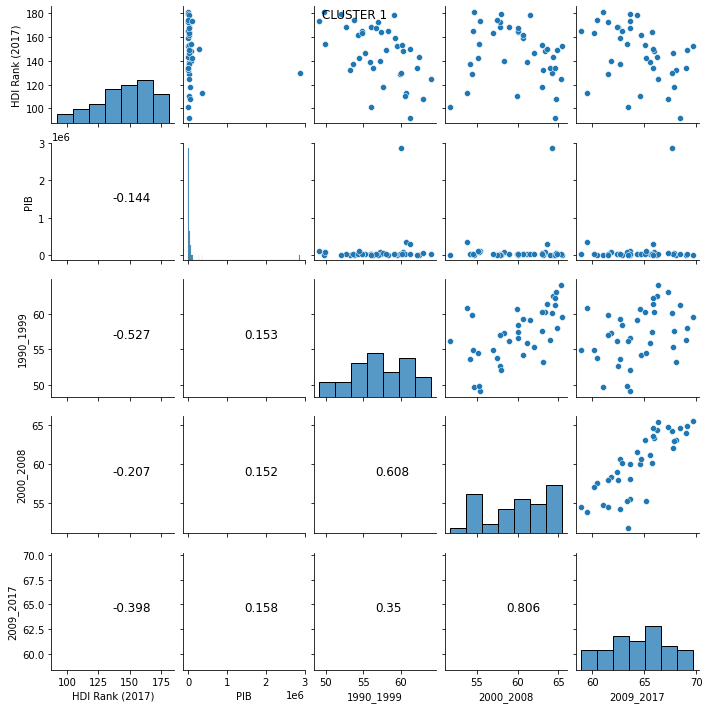

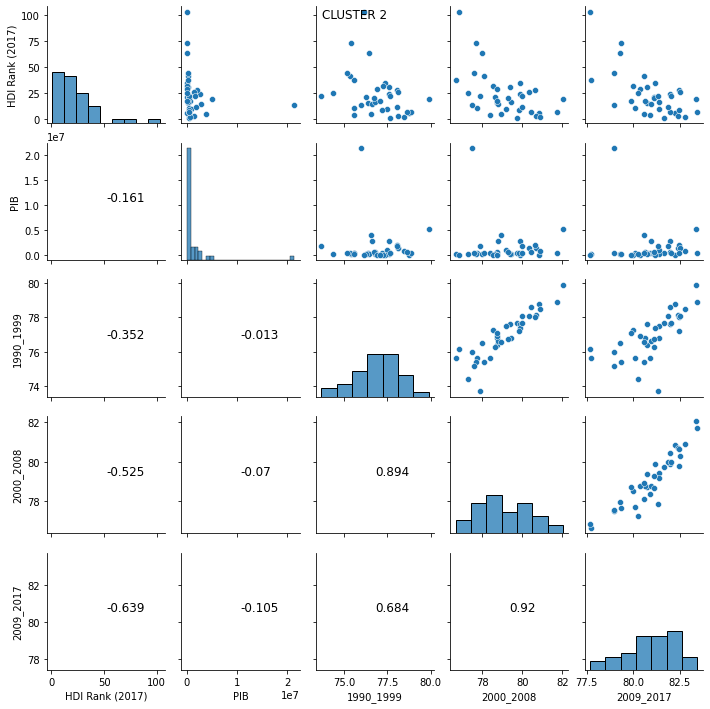

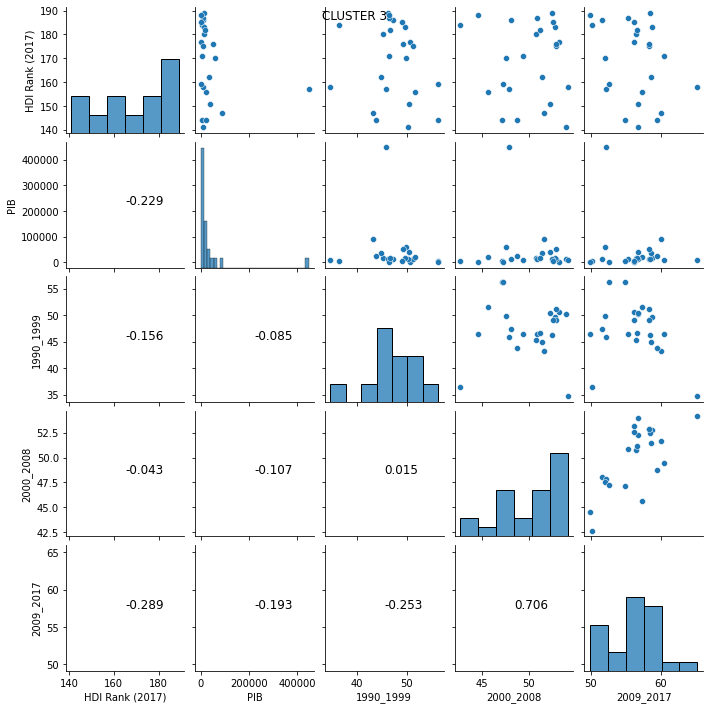

In [20]:
def plot_pares(cluster=None):
    if cluster == None:
        expect_vida_grp = expect_vida
    else:
        expect_vida_grp = expect_vida.query("cluster == @cluster")

    # matriz de correlaciones
    grid = sb.pairplot(
        expect_vida_grp,
        height=2, 
        vars=["HDI Rank (2017)", "PIB", "1990_1999", "2000_2008", "2009_2017"],
        kind='scatter'
    )

    def pintarCorr(x, y, **kwargs):
        plt.gca().clear()
        plt.gca().scatter(x, y, color="white")

        # calcular correlacion de pearson
        corr = round(np.corrcoef(x, y)[0,1], 3)
        plt.gca().text((max(x) + min(x))/2, (max(y) + min(y))/2, s=str(corr), fontsize=12)

    # pintar la correlacion en la parte inferior de la diagonal
    grid.map_lower(pintarCorr)

    plt.suptitle(f"CLUSTER {cluster}")
    plt.show()

for cont in range(0, 3 + 1):
    plot_pares(cont)

### analisis especifico de Colombia

In [21]:
expect_vida.query("Country == 'Colombia'")

,Continent,Country,PIB,HDI Rank (2017),1990_1999,2000_2008,2009_2017,cluster
82,South America,Colombia,323615.0,90,69.37,72.033333,73.844444,0


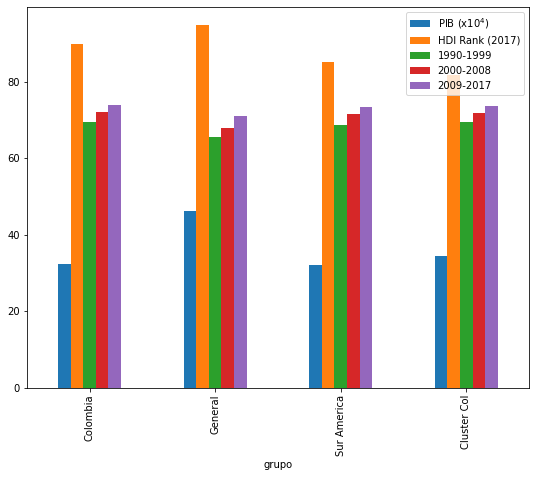

In [22]:
analisis_col = pd.concat(
    [
    expect_vida.query("Country == 'Colombia'").iloc[:, 2:-1].squeeze(),                 # datos de colombia
    expect_vida.iloc[:, 2:-1].mean(axis="index"),                                       # datos generales del dataframe
    expect_vida.query("Continent == 'South America'").iloc[:, 2:-1].mean(axis="index"), # datos de suramerica
    expect_vida.query("cluster == 0").iloc[:, 2:-1].mean(axis="index")                  # datos del cluster al que pertenece colombia
    ],
    axis="columns"
)
analisis_col = analisis_col.T

analisis_col["grupo"] = ["Colombia", "General", "Sur America", "Cluster Col"]
analisis_col.set_index("grupo", inplace=True)
analisis_col["PIB"] /= 1e4  # reducir la escala del PIB para que quepa en la grafica

# graficar los datos
ax = analisis_col.plot.bar(figsize=(9,7))
ax.legend([
    'PIB (x$10^4$)',
    'HDI Rank (2017)',
    '1990-1999',
    '2000-2008',
    '2009-2017'
])

plt.show()

# 5. Descripcion de tendencias encontradas en los datos y Conclusiones generales
- **De las graficas de promedio de esperanza de vida por cluster, se pueden observar una diferencia marcada en la esperanza de vida en cada cluster.**

  - Cluster 0: su esperanza de vida es en promedio la segunda mejor de todos los datos, si miramos la tabla de paises por cluster podemos ver paises como: Poland, Argentina, Lithuania, Dominican Republic. Paises que podriamos considerar como paises en desarrollo pero que ya han alcansado un nivel considerable de desarrollo, sin embargo es el cluster con mas paises en el, asi que hay paises que podriamos considerar como menos o mas desarrollados.

  - Cluster 1: su esperanza de vida es considerablemente baja en promedio. en este cluster hay paises como: India, Sudan, Haiti, Congo. Paises igualmente en desarrollo pero aun con bajos niveles de desarrollo.

  - Cluster 2: su esperanza de vida es la mejor de todos los clusters en promedio. en este cluster hay paises como: Germany, Portugal, Iceland,Finland, Denmark. La inmensa mayoria de paises de este cluster son paises que se pueden considerar paises de primer mundo

  - Cluster 3: su esperanza de vida es en contraste la peor de todos los clusters en promedio. en este cluster hay paises como: Guinea, South Sudan,Sierra Leone, Zimbabwe, Mali, Burkina Faso. Paises que podriamos considerar como paises subdesarrollados

- **De las graficas de PIB promedio se puede ver que los clusters que tiene esperanzas de vida mayores tambien suelen tener PIB mayores, Tambien se nota que sobre todo los paises del cluster 2 tiene un PIB que es bastante mayor al resto de los paises, incluso con los del cluster 0 que es el segundo cluster con mayor esperanza de vida, se nota una gran diferencia en PIB entre el clsuter 2 y 0. Esto nos podria estar hablando de una gran desigualdad al menos en terminos de PIB entre los paises del cluster 2 y el resto de paises**

- **De la tabla de paises por cluster y continente podemos ver algunas cosas a resaltar**:
  - Para Africa la mayoria de paises pertenecen al cluster 3, seguido por el cluster 1, ambos siendo clusters con una mala esperanza de vida. Algo a resaltar es que Africa es el unico continente que tiene paises que pertenecen al cluster 3.

  - Asia tiene mayoritariamente paises en los cluster 0 y 1, lo que nos puede indicar que los paises asiaticos son paises que respecto a la esperanza de vida estan en vias de desarrollo

  - Europa solo tiene paises en los clusters 0 y 2, los de mejor esperanza de vida. Cabe resaltar que Europa es el continente con mas paises en el cluster 2, el mejor de todos.

  - Norte America tiene paises en los clusters 0, 1 y 2. En el cluster 2 de Norte America estan paises que esperariamos ver aca como lo son Canada y Estados Unidos, pero tambien esta Cuba, un pais que no se esperaria ver en el cluster 2.

  - Oceania tiene paises en los clusters 0, 1 y 2. Al igual que con Norte America, los paises del cluster 2 son paises que consideramos como desarrollados, en este caso son Australia y Nueva Zelanda.

  - Sur America tiene paises en los clusters 0, 1 y 2, donde la mayoria de paises estan en el cluster 0, lo que nos da indicios de que Sur America es una region en desarrollo con un cierto grado de desarrollo alcanzado, tambien cabe resaltar que el unico pais del cluster 2 en Sur America es chile, siendo curioso que solo 1 pais en Sur America cayera en este cluster.

- **De la grafica de pares con correlaciones general (presentada en el punto 1) se ve una correlacion lineal alta entre las columnas 1990_1999, 2000_2008, 2009_2017 y HDI Rank (2017), en este caso negativa, pero tambien existe una correlacion alta entre estas mismas variables, pero positiva, esto nos indica que estas varaibles estan relacionadas entre si y tambien estan relacionadas con la variable HDI Rank (2017). Sin embargo si miramos luego las graficas de pares con correlaciones por cluster, podemos ver que estas relaciones se difuminan, llegando incluso a valores de correlacion lineal cercanos a 0.**

- **Haciendo un analisis especifico para Colombia podemos ver lo siguiente:**
  - Colombia esta en el cluster 0
  - El PIB de colombia comparado con el promedio global, es considerablemente menor, seguramente debido a esas desigualdades vistas en los puntos anteriores, sin embargo es mayor al promedio de Sur America y al promedio de los paises que pertenecen al cluster 0.
  - El HDI rank de colombia esta levemente por debajo del promedio mundial, pero por encima del promedio de Sur America y del cluster 0.
  - Respecto a las variables 1990_1999, 2000_2008, 2009_2017 de esperanza de vida. Podemos ver que Colombia esta levemente por encima del promedio mundial probablemente debido a que los paises Africanos suelen tener promedios de esperanza de vida bajos como se ve en las graficas de promedio de esperanza de vida, Luego comparado con Sur America y el cluster 0 se ve que son casi iguales, realmente no es posible persibir una diferencia entre la esperanza de vida de Colombia y el promedio de Sur America y el cluster 0.